## SQL with Spark SQL and DataFrames
Spark SQL brings native support for SQL to Spark and streamlines the process of querying data stored both in RDDs (Spark’s distributed datasets) and in external sources. Spark SQL conveniently blurs the lines between RDDs and relational tables. Unifying these powerful abstractions makes it easy for developers to intermix SQL commands querying external data with complex analytics, all within in a single application. Concretely, Spark SQL will allow developers to:

- Import relational data from Parquet files and Hive tables
- Run SQL queries over imported data and existing RDDs
- Easily write RDDs out to Hive tables or Parquet files

Spark SQL also includes a cost-based optimizer, columnar storage, and code generation to make queries fast. At the same time, it scales to thousands of nodes and multi-hour queries using the Spark engine, which provides full mid-query fault tolerance, without having to worry about using a different engine for historical data.

Dataset: the KDD Cup 1999 (http://kdd.ics.uci.edu/databases/kddcup99/kddcup99.html)

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [3]:
# Dealing with datasets retrieved from the web can be a bit tricky in Databricks. 
# Fortunately, we have some excellent utility packages like dbutils which help in making our job easier. 
# Let's take a quick look at some essential functions for this module.
dbutils.help()

This module provides various utilities for users to interact with the rest of Databricks.
 credentials: DatabricksCredentialUtils -> Utilities for interacting with credentials within notebooks fs: DbfsUtils -> Manipulates the Databricks filesystem (DBFS) from the console library: LibraryUtils -> Utilities for session isolated libraries meta: MetaUtils -> Methods to hook into the compiler (EXPERIMENTAL) notebook: NotebookUtils -> Utilities for the control flow of a notebook (EXPERIMENTAL) preview: Preview -> Utilities under preview category secrets: SecretUtils -> Provides utilities for leveraging secrets within notebooks widgets: WidgetsUtils -> Methods to create and get bound value of input widgets inside notebooks

In [4]:
# leverage the python urllib library to extract the KDD Cup 99 data from their web repository, store it in a temporary location and 
# then move it to the Databricks filesystem which can enable easy access to this data for analysis
import urllib.request
urllib.request.urlretrieve("http://kdd.ics.uci.edu/databases/kddcup99/kddcup.data_10_percent.gz", "/tmp/kddcup_data.gz")

dbutils.fs.mv("file:/tmp/kddcup_data.gz", "dbfs:/kdd/kddcup_data.gz")
display(dbutils.fs.ls("dbfs:/kdd"))

path,name,size
dbfs:/kdd/kddcup_data.gz,kddcup_data.gz,2144903


In [5]:
# Building the KDD Dataset
data_file = "dbfs:/kdd/kddcup_data.gz"
raw_rdd = sc.textFile(data_file).cache()
raw_rdd.take(5)

Out[ 5 ]: 
['0,tcp,http,SF,181,5450,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,8,8,0.00,0.00,0.00,0.00,1.00,0.00,0.00,9,9,1.00,0.00,0.11,0.00,0.00,0.00,0.00,0.00,normal.',
 '0,tcp,http,SF,239,486,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,8,8,0.00,0.00,0.00,0.00,1.00,0.00,0.00,19,19,1.00,0.00,0.05,0.00,0.00,0.00,0.00,0.00,normal.',
 '0,tcp,http,SF,235,1337,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,8,8,0.00,0.00,0.00,0.00,1.00,0.00,0.00,29,29,1.00,0.00,0.03,0.00,0.00,0.00,0.00,0.00,normal.',
 '0,tcp,http,SF,219,1337,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,6,6,0.00,0.00,0.00,0.00,1.00,0.00,0.00,39,39,1.00,0.00,0.03,0.00,0.00,0.00,0.00,0.00,normal.',
 '0,tcp,http,SF,217,2032,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,6,6,0.00,0.00,0.00,0.00,1.00,0.00,0.00,49,49,1.00,0.00,0.02,0.00,0.00,0.00,0.00,0.00,normal.']

In [6]:
# Building a Spark DataFrame
from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)
sqlContext 

Out[ 6 ]: <pyspark.sql.context.SQLContext at 0x7f81029de0b8>

In [7]:
# Splitting the CSV data
csv_rdd = raw_rdd.map(lambda row: row.split(","))
print(csv_rdd.take(2))
print(type(csv_rdd))

[['0', 'tcp', 'http', 'SF', '181', '5450', '0', '0', '0', '0', '0', '1', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '8', '8', '0.00', '0.00', '0.00', '0.00', '1.00', '0.00', '0.00', '9', '9', '1.00', '0.00', '0.11', '0.00', '0.00', '0.00', '0.00', '0.00', 'normal.'], ['0', 'tcp', 'http', 'SF', '239', '486', '0', '0', '0', '0', '0', '1', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '8', '8', '0.00', '0.00', '0.00', '0.00', '1.00', '0.00', '0.00', '19', '19', '1.00', '0.00', '0.05', '0.00', '0.00', '0.00', '0.00', '0.00', 'normal.']]
<class 'pyspark.rdd.PipelinedRDD'>

In [8]:
# Check the total number of features (columns)
len(csv_rdd.take(1)[0])

Out[ 8 ]: 42

In [9]:
# Data Understanding and Parsing
from pyspark.sql import Row

parsed_rdd = csv_rdd.map(lambda r: Row(
    duration=int(r[0]), 
    protocol_type=r[1],
    service=r[2],
    flag=r[3],
    src_bytes=int(r[4]),
    dst_bytes=int(r[5]),
    wrong_fragment=int(r[7]),
    urgent=int(r[8]),
    hot=int(r[9]),
    num_failed_logins=int(r[10]),
    num_compromised=int(r[12]),
    su_attempted=r[14],
    num_root=int(r[15]),
    num_file_creations=int(r[16]),
    label=r[-1]
    )
)
parsed_rdd.take(5)

Out[ 9 ]: 
[Row(dst_bytes=5450, duration=0, flag='SF', hot=0, label='normal.', num_compromised=0, num_failed_logins=0, num_file_creations=0, num_root=0, protocol_type='tcp', service='http', src_bytes=181, su_attempted='0', urgent=0, wrong_fragment=0),
 Row(dst_bytes=486, duration=0, flag='SF', hot=0, label='normal.', num_compromised=0, num_failed_logins=0, num_file_creations=0, num_root=0, protocol_type='tcp', service='http', src_bytes=239, su_attempted='0', urgent=0, wrong_fragment=0),
 Row(dst_bytes=1337, duration=0, flag='SF', hot=0, label='normal.', num_compromised=0, num_failed_logins=0, num_file_creations=0, num_root=0, protocol_type='tcp', service='http', src_bytes=235, su_attempted='0', urgent=0, wrong_fragment=0),
 Row(dst_bytes=1337, duration=0, flag='SF', hot=0, label='normal.', num_compromised=0, num_failed_logins=0, num_file_creations=0, num_root=0, protocol_type='tcp', service='http', src_bytes=219, su_attempted='0', urgent=0, wrong_fragment=0),
 Row(dst_bytes=2032, duration=0, flag='SF', hot=0, label='normal.', num_compromised=0, num_failed_logins=0, num_file_creations=0, num_root=0, protocol_type='tcp', service='http', src_bytes=217, su_attempted='0', urgent=0, wrong_fragment=0)]

In [10]:
# Constructing the DataFrame
df = sqlContext.createDataFrame(parsed_rdd)
display(df.head(10))

dst_bytes,duration,flag,hot,label,num_compromised,num_failed_logins,num_file_creations,num_root,protocol_type,service,src_bytes,su_attempted,urgent,wrong_fragment
5450,0,SF,0,normal.,0,0,0,0,tcp,http,181,0,0,0
486,0,SF,0,normal.,0,0,0,0,tcp,http,239,0,0,0
1337,0,SF,0,normal.,0,0,0,0,tcp,http,235,0,0,0
1337,0,SF,0,normal.,0,0,0,0,tcp,http,219,0,0,0
2032,0,SF,0,normal.,0,0,0,0,tcp,http,217,0,0,0
2032,0,SF,0,normal.,0,0,0,0,tcp,http,217,0,0,0
1940,0,SF,0,normal.,0,0,0,0,tcp,http,212,0,0,0
4087,0,SF,0,normal.,0,0,0,0,tcp,http,159,0,0,0
151,0,SF,0,normal.,0,0,0,0,tcp,http,210,0,0,0
786,0,SF,1,normal.,0,0,0,0,tcp,http,212,0,0,0


In [11]:
#  look at our dataframe's schema
df.printSchema()

root
-- dst_bytes: long (nullable = true)
-- duration: long (nullable = true)
-- flag: string (nullable = true)
-- hot: long (nullable = true)
-- label: string (nullable = true)
-- num_compromised: long (nullable = true)
-- num_failed_logins: long (nullable = true)
-- num_file_creations: long (nullable = true)
-- num_root: long (nullable = true)
-- protocol_type: string (nullable = true)
-- service: string (nullable = true)
-- src_bytes: long (nullable = true)
-- su_attempted: string (nullable = true)
-- urgent: long (nullable = true)
-- wrong_fragment: long (nullable = true)

In [12]:
# Building a temporary table
help(df.registerTempTable)

Help on method registerTempTable in module pyspark.sql.dataframe:

registerTempTable(name) method of pyspark.sql.dataframe.DataFrame instance
 Registers this DataFrame as a temporary table using the given name.
 
 The lifetime of this temporary table is tied to the :class:`SparkSession`
 that was used to create this :class:`DataFrame`.
 
 >>> df.registerTempTable("people")
 >>> df2 = spark.sql("select * from people")
 >>> sorted(df.collect()) == sorted(df2.collect())
 True
 >>> spark.catalog.dropTempView("people")
 
 .. note:: Deprecated in 2.0, use createOrReplaceTempView instead.
 
 .. versionadded:: 1.3

In [13]:
df.registerTempTable("connections")

In [14]:
# Connections based on the protocol type
display(df.groupBy('protocol_type')
          .count()
          .orderBy('count', ascending=False))

protocol_type,count
icmp,283602
tcp,190065
udp,20354


In [15]:
# use SQL to perform the same aggregation
protocols = sqlContext.sql("""
                           SELECT protocol_type, count(*) as freq
                           FROM connections
                           GROUP BY protocol_type
                           ORDER BY 2 DESC
                           """)
display(protocols)

protocol_type,freq
icmp,283602
tcp,190065
udp,20354


In [16]:
# check the total number of connections based on good (normal) or bad (intrusion attacks) types.
labels = sqlContext.sql("""
                           SELECT label, count(*) as freq
                           FROM connections
                           GROUP BY label
                           ORDER BY 2 DESC
                           """)
display(labels)

label,freq
smurf.,280790
neptune.,107201
normal.,97278
back.,2203
satan.,1589
ipsweep.,1247
portsweep.,1040
warezclient.,1020
teardrop.,979
pod.,264


In [17]:
# in bar plot
labels = sqlContext.sql("""
                           SELECT label, count(*) as freq
                           FROM connections
                           GROUP BY label
                           ORDER BY 2 DESC
                           """)
display(labels)

label,freq
smurf.,280790
neptune.,107201
normal.,97278
back.,2203
satan.,1589
ipsweep.,1247
portsweep.,1040
warezclient.,1020
teardrop.,979
pod.,264


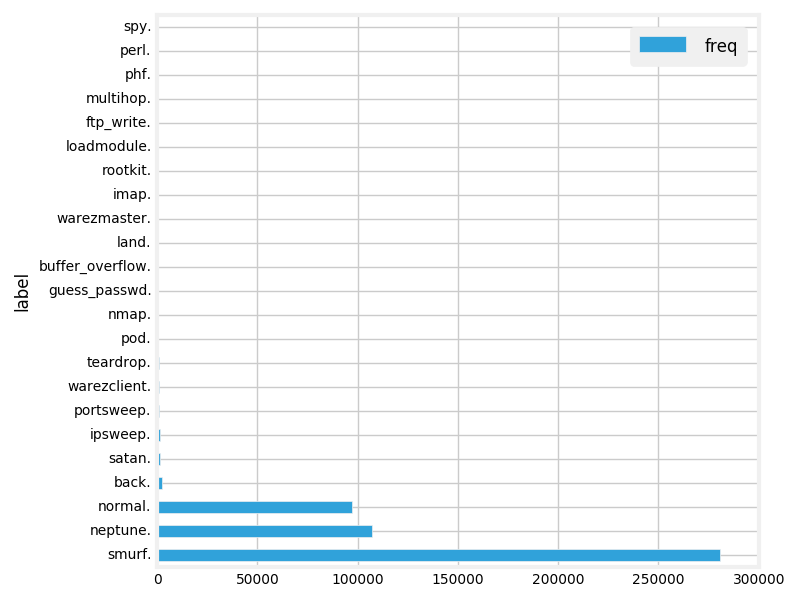

In [18]:
# use DataFrame
labels_df = pd.DataFrame(labels.toPandas())
labels_df.set_index("label", drop=True,inplace=True)
labels_fig = labels_df.plot(kind='barh')

plt.rcParams["figure.figsize"] = (7, 5)
plt.rcParams.update({'font.size': 10})
plt.tight_layout()
display(labels_fig.figure)

In [19]:
# Connections based on protocols and attacks
attack_protocol = sqlContext.sql("""
                           SELECT 
                             protocol_type, 
                             CASE label
                               WHEN 'normal.' THEN 'no attack'
                               ELSE 'attack'
                             END AS state,
                             COUNT(*) as freq
                           FROM connections
                           GROUP BY protocol_type, state
                           ORDER BY 3 DESC
                           """)
display(attack_protocol)

protocol_type,state,freq
icmp,attack,282314
tcp,attack,113252
tcp,no attack,76813
udp,no attack,19177
icmp,no attack,1288
udp,attack,1177


In [20]:
attack_stats = sqlContext.sql("""
                           SELECT 
                             protocol_type, 
                             CASE label
                               WHEN 'normal.' THEN 'no attack'
                               ELSE 'attack'
                             END AS state,
                             COUNT(*) as total_freq,
                             ROUND(AVG(src_bytes), 2) as mean_src_bytes,
                             ROUND(AVG(dst_bytes), 2) as mean_dst_bytes,
                             ROUND(AVG(duration), 2) as mean_duration,
                             SUM(num_failed_logins) as total_failed_logins,
                             SUM(num_compromised) as total_compromised,
                             SUM(num_file_creations) as total_file_creations,
                             SUM(su_attempted) as total_root_attempts,
                             SUM(num_root) as total_root_acceses
                           FROM connections
                           GROUP BY protocol_type, state
                           ORDER BY 3 DESC
                           """)
display(attack_stats)

protocol_type,state,total_freq,mean_src_bytes,mean_dst_bytes,mean_duration,total_failed_logins,total_compromised,total_file_creations,total_root_attempts,total_root_acceses
icmp,attack,282314,932.14,0.0,0.0,0,0,0,0.0,0
tcp,attack,113252,9880.38,881.41,23.19,57,2269,76,1.0,152
tcp,no attack,76813,1439.31,4263.97,11.08,18,2776,459,17.0,5456
udp,no attack,19177,98.01,89.89,1054.63,0,0,0,0.0,0
icmp,no attack,1288,91.47,0.0,0.0,0,0,0,0.0,0
udp,attack,1177,27.5,0.23,0.0,0,0,0,0.0,0


In [21]:
# Filtering connection stats
tcp_attack_stats = sqlContext.sql("""
                                   SELECT 
                                     service,
                                     label as attack_type,
                                     COUNT(*) as total_freq,
                                     ROUND(AVG(duration), 2) as mean_duration,
                                     SUM(num_failed_logins) as total_failed_logins,
                                     SUM(num_file_creations) as total_file_creations,
                                     SUM(su_attempted) as total_root_attempts,
                                     SUM(num_root) as total_root_acceses
                                   FROM connections
                                   WHERE protocol_type = 'tcp'
                                   AND label != 'normal.'
                                   GROUP BY service, attack_type
                                   ORDER BY total_freq DESC
                                   """)
display(tcp_attack_stats)

service,attack_type,total_freq,mean_duration,total_failed_logins,total_file_creations,total_root_attempts,total_root_acceses
private,neptune.,101317,0.0,0,0,0.0,0
http,back.,2203,0.13,0,0,0.0,0
other,satan.,1221,0.0,0,0,0.0,0
private,portsweep.,725,1915.81,0,0,0.0,0
ftp_data,warezclient.,708,403.71,0,0,0.0,0
ftp,warezclient.,307,1063.79,0,0,0.0,0
other,portsweep.,260,1058.22,0,0,0.0,0
telnet,neptune.,197,0.0,0,0,0.0,0
http,neptune.,192,0.0,0,0,0.0,0
finger,neptune.,177,0.0,0,0,0.0,0


In [22]:
# Imposing some constraints based on duration, file creations, root accesses in the query.
tcp_attack_stats = sqlContext.sql("""
                                   SELECT 
                                     service,
                                     label as attack_type,
                                     COUNT(*) as total_freq,
                                     ROUND(AVG(duration), 2) as mean_duration,
                                     SUM(num_failed_logins) as total_failed_logins,
                                     SUM(num_file_creations) as total_file_creations,
                                     SUM(su_attempted) as total_root_attempts,
                                     SUM(num_root) as total_root_acceses
                                   FROM connections
                                   WHERE (protocol_type = 'tcp'
                                          AND label != 'normal.')
                                   GROUP BY service, attack_type
                                   HAVING (mean_duration >= 50
                                           AND total_file_creations >= 5
                                           AND total_root_acceses >= 1)
                                   ORDER BY total_freq DESC
                                   """)
display(tcp_attack_stats)

service,attack_type,total_freq,mean_duration,total_failed_logins,total_file_creations,total_root_attempts,total_root_acceses
telnet,buffer_overflow.,21,130.67,0,15,0.0,5
telnet,loadmodule.,5,63.8,0,9,0.0,3
telnet,multihop.,2,458.0,0,8,0.0,93


In [23]:
# Subqueries to filter TCP attack types based on service
tcp_attack_stats = sqlContext.sql("""
                                   SELECT 
                                     t.service,
                                     t.attack_type,
                                     t.total_freq
                                   FROM
                                   (SELECT 
                                     service,
                                     label as attack_type,
                                     COUNT(*) as total_freq,
                                     ROUND(AVG(duration), 2) as mean_duration,
                                     SUM(num_failed_logins) as total_failed_logins,
                                     SUM(num_file_creations) as total_file_creations,
                                     SUM(su_attempted) as total_root_attempts,
                                     SUM(num_root) as total_root_acceses
                                   FROM connections
                                   WHERE protocol_type = 'tcp'
                                   AND label != 'normal.'
                                   GROUP BY service, attack_type
                                   ORDER BY total_freq DESC) as t
                                     WHERE t.mean_duration > 0 
                                   """)
display(tcp_attack_stats)


service,attack_type,total_freq
http,back.,2203
private,portsweep.,725
ftp_data,warezclient.,708
ftp,warezclient.,307
other,portsweep.,260
private,satan.,170
telnet,guess_passwd.,53
telnet,buffer_overflow.,21
ftp_data,warezmaster.,18
imap4,imap.,12


In [24]:
# Building a Pivot Table from Aggregated Data
display((tcp_attack_stats.groupby('service')
                         .pivot('attack_type')
                         .agg({'total_freq':'max'})
                         .na.fill(0))
)

service,back.,buffer_overflow.,ftp_write.,guess_passwd.,imap.,ipsweep.,loadmodule.,multihop.,perl.,phf.,portsweep.,rootkit.,satan.,spy.,warezclient.,warezmaster.
telnet,0,21,0,53,0,1,5,2,3,0,0,5,1,2,0,0
ftp,0,1,2,0,0,1,1,2,0,0,0,1,1,0,307,2
pop_3,0,0,0,0,0,0,0,0,0,0,3,0,1,0,0,0
discard,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
login,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0
smtp,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0
domain,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
http,2203,0,0,0,0,3,0,0,0,4,3,0,0,0,0,0
courier,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
other,0,0,0,0,0,0,0,0,0,0,260,0,0,0,5,0
